## backtest disclosures sentiment

TODO:
* some disclosures are not "wordy" enough so sentiment is not useful
* compare sentiments using nltk and textblob
  - compute sentiment per sentence or for entire text?
* incorporate trading strategy to fastquant.strategy module
* fine tune `senti_change` parameter

In [19]:
from fastquant import DisclosuresPSE

dpse = DisclosuresPSE("JFC", start_date="01-01-2015")

Pulling JFC disclosures summary...
3 pages detected!
Found 142 disclosures between 01-01-2015 & 06-13-2020 with 16 types:
["Notice of Annual or Special Stockholders' Meeting" 'Press Release'
 'Material Information/Transactions'
 "Notice of Analysts'/Investors' Briefing" 'Declaration of Cash Dividends'
 'Joint Ventures' 'Change in Corporate Contact Details and/or Website'
 'Substantial Acquisitions' 'Clarification of News Reports'
 "Results of Annual or Special Stockholders' Meeting"
 'Results of Organizational Meeting of Board of Directors'
 'Acquisition or Disposition of Shares of Another Corporation'
 'Change in Directors and/or Officers (Resignation, Removal or Appointment, Election and/or Promotion)'
 'Amendments to By-Laws' 'Amendments to Articles of Incorporation'
 'Update on Corporate Actions/Material Transactions/Agreements']
Pulling details in all JFC disclosures...


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Loaded: /home/jp/miniconda3/envs/quant/lib/python3.8/site-packages/fastquant/data/JFC_disclosures_01-01-2015_06-13-2020.csv


In [20]:
dpse.disclosures_combined.head()

,Company Name,Template Name,PSE Form Number,Announce Date and Time,Circular Number,edge_no,url,disclosure_table,Background/Description of the Disclosure,Subject of the Disclosure
0,Jollibee Foods Corporation,Notice of Annual or Special Stockholders' Meeting,7-1,2020-05-28 07:23:00,C03757-2020,3d7278efdfc3720b0de8473cebbd6407,https://edge.pse.com.ph/openDiscViewer.do?edge...,"{""Title of Each Class"": ""COMMON"", ""Subject of ...",Notice of annual stockholders' meeting for the...,Notice of annual stockholders' meeting for the...
1,Jollibee Foods Corporation,Press Release,4-31,2020-05-28 07:17:00,C03749-2020,55ee488e963620db0de8473cebbd6407,https://edge.pse.com.ph/openDiscViewer.do?edge...,"{""Title of Each Class"": ""Common"", ""Subject of ...",JFC Announces First Quarter 2020 Financial Res...,Press Release: 2020 1st Quarter Financial Results
2,Jollibee Foods Corporation,Material Information/Transactions,4-30,2020-05-22 11:03:00,C03610-2020,60b39b927aef3f460de8473cebbd6407,https://edge.pse.com.ph/openDiscViewer.do?edge...,"{""Title of Each Class"": ""Common"", ""Subject of ...","Jollibee Foods Corporation, one of Asia's larg...",JFC to Spend Php7 Billion for Business Transfo...
3,Jollibee Foods Corporation,Notice of Analysts'/Investors' Briefing,14-1,2020-05-22 07:11:00,C03594-2020,81ed19ddd867a1970de8473cebbd6407,https://edge.pse.com.ph/openDiscViewer.do?edge...,"{""Title of Each Class"": ""common "", ""Subject of...",Jollibee Foods Corporation will do an Earnings...,JFC’s Earnings Call for its First Quarter 2020...
4,Jollibee Foods Corporation,Press Release,4-31,2020-04-15 07:41:00,C02771-2020,2fd88ba354823b280de8473cebbd6407,https://edge.pse.com.ph/openDiscViewer.do?edge...,"{""Title of Each Class"": ""Common"", ""Subject of ...",JFC Reports 2019 Results Based on Audited Fina...,Press Release: 2019 Audited Financial Results


In [21]:
#!pip install nltk

In [22]:
import nltk
import warnings
warnings.filterwarnings('ignore')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

In [23]:
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

In [24]:
import numpy as np

date_sentiments = {}
for idx,row in dpse.disclosures_combined.iterrows():
    date = row['Announce Date and Time'].date()
    paragraph = row['Background/Description of the Disclosure']
    
    sentiments=[]
    if paragraph is not None:
        #split paragraph into sentences 
        sentences = nltk.sent_tokenize(paragraph)
        for sentence in sentences: 
            sentiment = sia.polarity_scores(sentence)['compound']
            sentiments.append(sentiment)
        sentiment = np.mean(sentiments)
        #sentiment = sia.polarity_scores(paragraph)['compound']
        date_sentiments[date] = sentiment

<IPython.core.display.Javascript object>


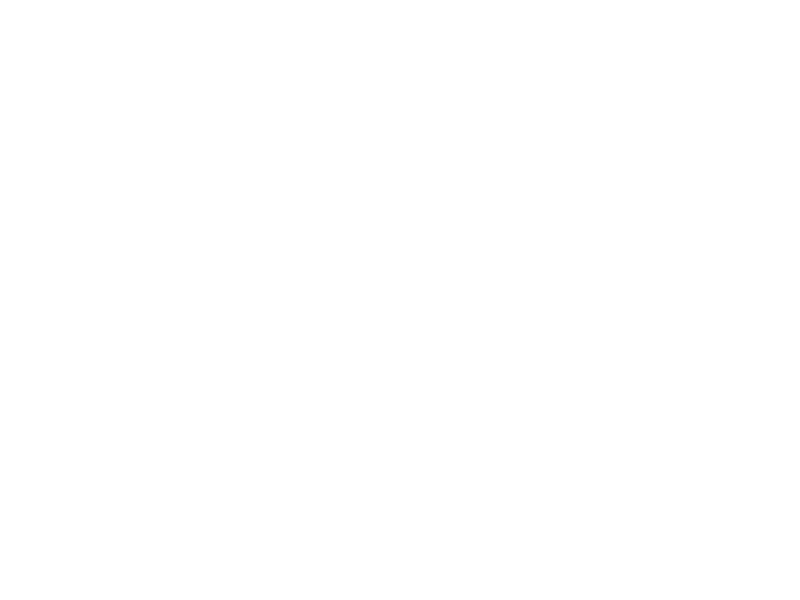

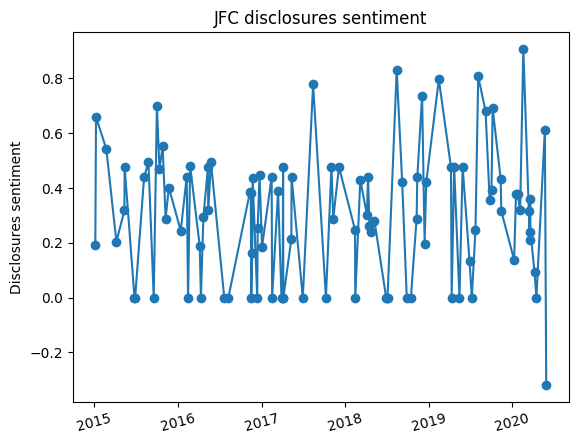

In [25]:
import pandas as pd
import matplotlib.pyplot as pl
pl.style.use("default")

s = pd.Series(date_sentiments)
ax = s.plot(marker='o')
ax.set_ylabel("Disclosures sentiment")
ax.set_title(f"{dpse.symbol} disclosures sentiment")
for tick in ax.get_xticklabels():
    tick.set_rotation(15)

In [26]:
from __future__ import (absolute_import, division, print_function,
                            unicode_literals)
import matplotlib.pyplot as pl
pl.style.use("default")

import backtrader as bt
import backtrader.indicators as btind
from datetime import datetime
import os.path
import sys

verbose = False
senti_change = 0.2 #threshold of sentiment change

class Sentiment(bt.Indicator):
    lines = ('sentiment',)
    plotinfo = dict(
        plotymargin=0.15,
        plothlines=[0],
        plotyticks=[1.0, 0, -1.0])
    
    def next(self):
        self.date = self.data.datetime
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiments:
            self.sentiment = date_sentiments[date]
        self.lines.sentiment[0] = self.sentiment


class SentimentStrat(bt.Strategy):
    params = (
        ('period', 15),
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # Keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.period)
        self.date = self.data.datetime
        self.sentiment = None
        Sentiment(self.data)
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
                
            self.bar_executed = len(self)     
            
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        # Write down: no pending order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    ### Main Strat ###
    def next(self):
        # log closing price of the series from the reference
        if verbose:
            self.log('Close, %.2f' % self.dataclose[0])
        
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiments:
            self.sentiment = date_sentiments[date]
        
        # Check if an order is pending. if yes, we cannot send a 2nd one
        if self.order:
            return
        #print(self.sentiment)
        # If not in the market and previous sentiment not none
        if not self.position and prev_sentiment:
            # buy if current close more than sma AND sentiment increased by >= 0.5
            if (self.dataclose[0] > self.sma[0]) and (self.sentiment - prev_sentiment >= senti_change):
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()
                
        # Already in the market and previous sentiment not none
        elif prev_sentiment:
            # sell if current close less than sma AND sentiment decreased by >= 0.5
            if (self.dataclose[0] < self.sma[0]) and (self.sentiment - prev_sentiment <= -senti_change):
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.period, self.broker.getvalue()), doprint=True)     

Starting Portfolio Value: 100000.00
2016-11-23, BUY CREATE, 0.98
2016-11-25, BUY EXECUTED, Price: 0.97, Cost: 9.70, Comm 0.01
2017-02-16, SELL CREATE, 0.93
2017-02-17, SELL EXECUTED, Price: 0.94, Cost: 9.70, Comm 0.01
2017-02-17, OPERATION PROFIT, GROSS -0.30, NET -0.32
2018-12-03, BUY CREATE, 2.71
2018-12-04, BUY EXECUTED, Price: 2.76, Cost: 27.60, Comm 0.03
2019-05-15, SELL CREATE, 3.62
2019-05-16, SELL EXECUTED, Price: 3.53, Cost: 27.60, Comm 0.04
2019-05-16, OPERATION PROFIT, GROSS 7.70, NET 7.64
2020-06-12, (MA Period 15) Ending Value 100007.32
Final Portfolio Value: 100007.32


<IPython.core.display.Javascript object>


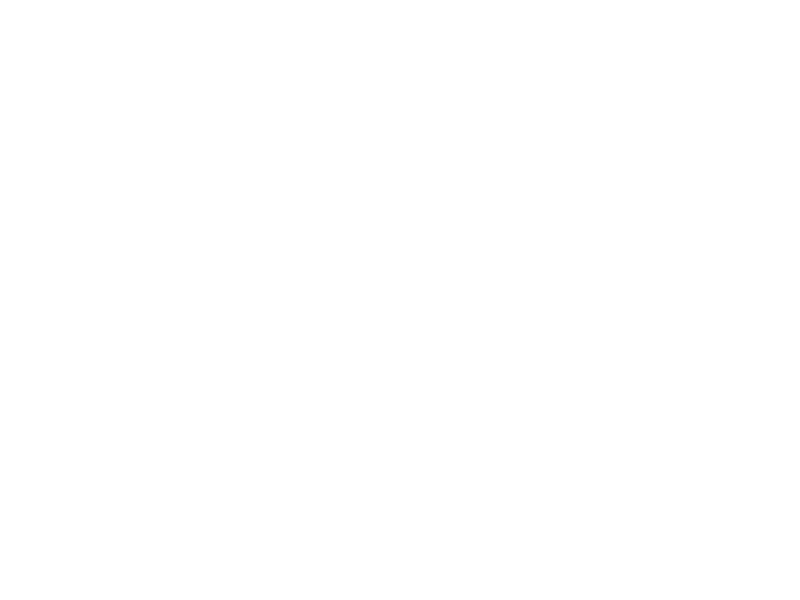

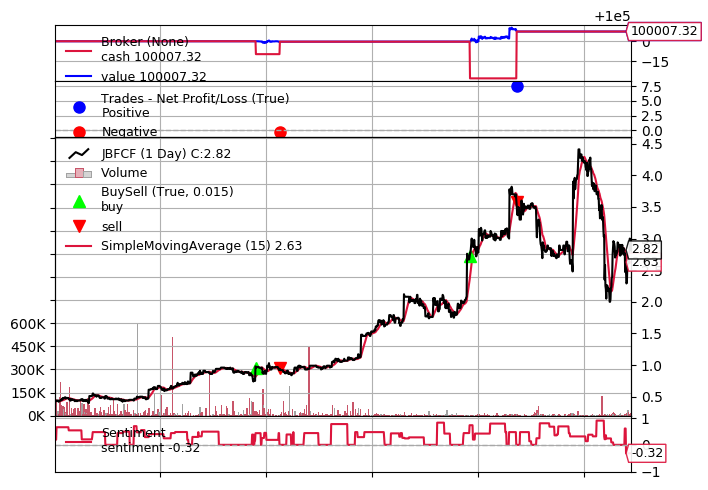

In [27]:
if __name__ == '__main__':
    cerebro = bt.Cerebro()
    
    # Strategy
    cerebro.addstrategy(SentimentStrat)

    # Data Feed
    data = bt.feeds.YahooFinanceData(
        dataname = 'JBFCF',
        fromdate = min(date_sentiments.keys()),
        todate = datetime.now().date(),
        reverse = False
    )
    
    cerebro.adddata(data)

    cerebro.broker.setcash(100000.0)
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)
    cerebro.broker.setcommission(commission=0.001)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    cerebro.plot()